# 자연어 처리
자연어 처리(natural language processing, NLP)는 **언어에 대한 계산적 기술을 의미**한다. 

## 21.1 워드 클라우드
단어와 그 개수를 시각화하는 한 가지 방법은 단어의 크기를 단어의 개수에 비례하도록 보여주는 워드 클라우드이다.

일반적으로 데이터 과학자들은 워드 클라우드를 선호하지 않는데, '이 곳에 단어를 끼워 넣을 공간이 있네' 정도 말고는 단어의 위치가 어떠한 의미도 가지지 않기 때문이다.

어쩌다가 워드 클라우드를 만들 상황이 온다면 각 축에 어떻게 의미를 부여할 수 있을지 고민해 보자. e.g. 데이터 과학과 연관된 각 유행어에 0-100 사이의 숫자 두 개가 주어졌다고 해보자. 첫 번째 숫자는 채용공고에 등장한 유행어의 빈도를, 두 번째는 이력서에 등장한 빈도를 의미한다.

In [2]:
data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]

채용공고에 등장하는 빈도를 가로축으로, 이력서에 등장하는 빈도를 세로축으로 설정한다면, 조금 더 많은 정보를 제공할 수 있다.

In [7]:
import matplotlib.pyplot as plt

def text_size(total: int) -> float:
    """total이 0이면 8, total이 200이면 28을 반환"""
    return 8 + total / 200 * 20

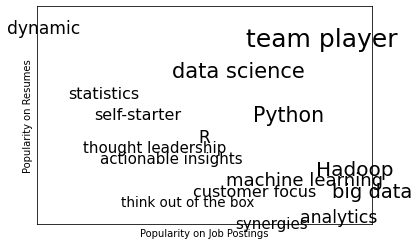

In [8]:
for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity, resume_popularity, word,
            ha='center', va='center',
            size=text_size(job_popularity + resume_popularity))

plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0, 100, 0, 100])
plt.xticks([])
plt.yticks([])
plt.show()

만약 위의 그림이 단순히 plot, x, y 축 위에 표현되지 않고 그저 빈도수가 높은 순으로 글자의 크기만 크게 그림으로 표현된다면 딱히 어떤 정보를 제공하지 않는다.

## 21.2 n-그램 언어모델
누군가 데이터 과학에 관한 수천 개의 웹페이지를 만들어 검색 엔진의 순위를 높이고 싶어한다. 프로그래밍으로 웹사이트를 대량으로 만들어 낼 방법이 없는지 궁금해하고 있다. 어떻게든 언어 모델을 만들 방법을 찾아야 한다.

한 가지 방법은 문서가 여러 개 있는 말뭉치(corpus, 코퍼스)를 구해서 언어에 대한 통계적 모델을 만드는 것이다. 여기서는 마이크 루키디스(Mike Loukides)의 에세이 What Is Data Science?를 사용해 보자.

9장 '파이썬으로 데이터 수집하기'에서와 같이 requests와 BeautifulSoup 라이브러리를 사용해서 데이터를 수집하자. 이때 신경 쓰면 좋을 몇가지 이슈가 있다.

첫째, 텍스트 안의 따옴표가 유니코드 문자 u\"u2019"이다. 이를 일반 아스키 따옴표로 바꾸는 함수를 만들자.

In [12]:
def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019", "'")

마침표를 기준으로 웹페이지 안의 텍스트에서 문장들을 봅아보자(마침표는 문장이 어디서 끝나는지를 알게 해주는 신호다.) 이것은 re.findall을 이용하면 간단하게 구현할 수 있다.

In [16]:
import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

content = soup.find("div", "article-body")  # article-body div를 찾아라.
regex = r"[\w']+|[\.]"  # 단어 또는 마침표를 찾아라.

document = []

for paragraph in content("p"):
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)

TypeError: 'NoneType' object is not callable

텍스트를 단어의 열로 만들었으니, 이제 다음과 같은 방법으로 언어를 모델링 할 수 있다. 먼저, 시작 단어를 하나 준다. 여기서는 이 단어를 'book'이라고 해보자. 그리고 문서들을 주욱 훑으면서 'book'이라는 단어 다음에 등장하는 단어들이 무엇인지 확인한다. 이 중 하나를 임의로 선택해서 다음 단어가 되게 하고, 문장 끝을 나타내는 마침표가 등장할 때까지 이 과정을 계속 반복한다. 주어진 문서의 바이그램(bigram, 2-gram) 빈도를 사용하기 때문에, 우리는 이러한 방식을 바이그램 모델(bigram model)이라고 부른다.

시작 단어는 어떻게 고를까? 마침표 다음에 등장하는 단어들 중에서 임의로 하나를 선택하는 방법이 있다. 각 단어 뒤에 어떤 단어가 따라오는지 계산해보자. zip은 입력된 리스트 중 하나라도 처리가 끝나면 종료되기 때문에, zip(document, document[1:]을 사용하면 document에서 연속해서 나온 단어들을 딱 맞게 보여줄 것이다.

In [17]:
from collections import defaultdict

transitions = defaultdict(list)
for prev, current in zip(document, document[1:]):
    transitions[prev].append(current)

이제 문장을 생성할 준비가 되었다.

In [18]:
def generate_using_bigrams() -> str:
    current = "."  # 마침표의 다음 단어가 문장을 새로 시작할 것이다.
    result = []
    while True:
        next_word_candidates = transitions[current]  # (current, _) 바이그램
        current = random.choice(next_word_candidates)  # 하나를 랜덤으로 골라라.
        result.append(current)  # results에 추가하라.
        if current == ".": return " ".join(result)  # "."가 나오면 종료해라.

이렇게 생성된 문장은 전혀 말이 되지 않지만, 웹사이트에서 데이터 과학의 느낌은 풍기기는 할 것이다. 

세 개의 연속된 단어를 보는 **트라이그램(trigram)** 을 사용하면 문장을 조금 더 그럴듯하게 만들 수 있다.(일반적으로는, n개의 연속된 단어를 고려하는 n-그램을 보겠지만, 여기서는 3개만 봐도 충분할 것이다.) 이제 다음 단어는 직전 두 개의 단어에 따라 바뀐다.

In [19]:
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in zip(document, document[1:], document[2:]):
    if prev == ".":  # 직전 단어가 마침표하면
        starts.append(current)  # current는 시작 단어가 될 수 있다.
        
    trigram_transitions[(prev, current)].append(next)

이번에는 시작 단어를 따로 관리해야 한다. 문장 생성 자체는 비슷한 방식으로 할 수 있다.

In [20]:
def generate_using_trigram() -> str:
    current = random.choice(starts)  # 임의의 시작 단어를 정한 후
    prev = "."  # 마침표를 앞에 덧붙인다.
    result = [current]
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next_word = random.choice(next_word_candidates)
        
        prev, current = current, next_word
        result.append(current)
        
        if current == ".":
            return " ".join(result)

트라이그램을 사용하면 좀 더 그럴듯한 문자들이 생성된다.

트라이그램에서 더 그럴듯한 문장들이 생성되는 이유는 다음 단어를 생성하는 각 단계에서 선택할 수 있는 단어의 수가 바이그램을 사용할 때보다 훨씬 적어지고, 많은 경우 딱 하나의 단어만 선택할 수밖에 없기 때문이다. 원문에 있었던 문장(또는 긴 문구)을 그대로 생성할 가능성도 높다. 데이터 과학 관련 에세이 여러 개 모아서 더 많은 데이터로 n-그램을 계산하면 성능이 더욱 좋아질 것이다.

## 21.3 문법 규칙
문뻐에 맞는 문장을 생성할 수 있도록 **문법 규칙**을 사용해서 언어를 모델링할 수도 있다.

In [21]:
from typing import List, Dict

# 문법 규칙을 나타내는 타입 별칭
Grammar = Dict[str, List[str]]

grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

여기서 항목 앞에 밑줄이 있으면 더 확장할 수 있는 규칙(rule), 나머지를 **종결어(terminal)** 라고 하자.

e.g. "_S"는 문장 규칙을 의미하며 "_NP"라는 명사구 규칙과 "_VP"라는 동사구 규칙을 생성한다.

동사규 규칙은 "_V"라는 동사 규칙을 생성하거나, 동사와 명사구로 이어지는 규칙을 생성할 수 있다.

"_NP" 규칙의 경우 자기 자신을 다시 생성할 수 있다는 것에 주목해보자.


문법 규칙은 재귀적(recursive)일 수 있기 때문에, 이와 같은 유한 문법(infinite grammars)이라도 무한히 많은 문장을 생성할 수 있다. 이 문법 규칙으로부터 문장을 어떻게 생성할까? 일단 문장 규칙 ["_S"]로부터 시작한다고 했을 때, 이를 대체할 수 있는 항목 중에서 임의로 한 가지를 선택하고, 모든 항목이 종결어일 때까지 이 과정을 반복한다.

예를 들어 아래와 같은 과정으로 문장이 생성될 수 있다.

['_S']

['_NP', '_VP']

['_N', '_VP']

['Python', '_VP']

['Python', '_V', '_NP']

['Python', 'trains', '_NP']

['Python', 'trains', '_A', '_NP', '_P', '_A', '_N']

['Python', 'trains', 'logistic', '_NP', '_P', '_A', '_N']

['Python', 'trains', 'logistic', '_N', '_P', '_A', '_N']

['Python', 'trains', 'logistic', 'data science', '_P', '_A', '_N']

['Python', 'trains', 'logistic', 'data science', 'about', '_A', '_N']

['Python', 'trains', 'logistic', 'data science', 'about', 'logistic', '_N']

['Python', 'trains', 'logistic', 'data science', 'about', 'logistic', 'Python']

이것을 실제 코드로 구현하기 위해 종결어를 인식할 수 있는 함수를 만들어 보자.

In [22]:
def is_terminal(token: str) -> bool:
    return token[0] != "_"

다음으로 토큰 목록이 주어졌을 때 이를 문장으로 변환하는 함수를 만들자. 이 함수에서는 가장 먼저 등장하는 규칙 항목이 무엇인지를 찾는다. 규칙 항목을 찾을 수 없다면 모든 항목이 종결어로 구성되어 있다는 것을 의미하므로 함수를 종료하면 되고, 규칙 항목을 찾는다면 그것을 대체할 수 있는 여러 항목 중 하나를 임의로 선택한다. 이때 선택된 항목이 종결어, 즉 단어라면 기존 항목을 단순히 대체하기만 하면 된다. 하편 선택된 항목이 종결어가 아니라면, 공백으로 구분된 비종료 토큰들을 split한 후 현재 토큰의 목록에 삽입해야 한다. 어떤 경우든, 새로 얻게 된 코큰의 목록에 대해 동일한 과정을 반복한다.

위 과정을 종합하면 아래와 같다.

In [23]:
def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
    for i, token in enumerate(tokens):
        # 종결어인 경우, 넘어가라.
        if is_terminal(token): continue
            
        # 종결어가 아닌 경우
        # 대체할 토큰을 임의로 정하라.
        replacement = random.choice(grammar[token])
        
        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            # 대체된 구가 예를 들어 "_NP _VP"라면
            # 공백을 기준으로 나누고 slice해서 넣어라.
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
            
        # 새로운 토큰 목록에 expand를 적용해라.
        return expand(grammar, tokens)
    
    # 여기까지 왔다면 리스트는 종결어만으로 구성되어 있고 프로세스는 종료된다.
    return tokens

이제 문장을 생성해 보자.

In [24]:
def generate_sentence(grammar: Grammar) -> List[str]:
    return expand(grammar, ["_S"])

사실 문법 규칙은 역으로 이용하는 게 더 흥미롭다. 즉, 주어진 문장을 문법 기준으로 **파싱(parsing)** 해서 명사와 동사 등을 인식한다면 문장을 더 잘 이해할 수 있다.

데이터 과학으로 문서를 생성하는 것도 꽤 멋지지만, 문서를 이해할 수 있는 것은 더욱 근사한 일이다. 

## 21.4 여담: 깁스 샘플링
몇몇 확률분포는 쉽게 표본(sample)을 생성할 수 있다. e.g. 균등분포의 확률변수(uniform random variable)는 다음과 같이 얻을 수 있고

random.random()

정규분포의 확률변수(normal random variables)는 다음과 같이 얻을 수 있다.

inverse_normal_cdf(random.random())

하지만 다른 일반적인 확률분포로부터 테이터를 샘플링하는 것은 간단하지 않다. 이런 경우 **깁스 샘플링(Gibbs sampling)** 은 다차원 분포 안, 몇 개의 조건부 분포(conditional distribution)를 알고 있다는 가정하에 표본을 생성할 수 있게 해준다.

두 개의 주사위를 상상해보자. x가 첫 번째 주사위의 눈이고 y는 주사위 두 개의 눈의 합일 때, (x, y)쌍을 여러 개 생성하려고 한다면 표본을 다음과 같이 직접 생성할 수 있다.

In [25]:
from typing import Tuple
import random

def roll_a_die() -> int:
    return random.choice([1,2,3,4,5,6])

def direct_sample() -> Tuple[int, int]:
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

이제 조건부 확률만 안다고 가정해 보자. x가 주어졌을 때 y의 조건부 확률을 구하는 것도 쉽다. x값을 안다면 y가 x+1, x+2, x+3, x+4, x+5 또는 x+6일 확률은 전부 같다.

In [26]:
def random_y_given_x(x: int) -> int:
    """x + 1, x + 2, ... , x + 6일 확률은 전부 동일하다."""
    return x + roll_a_die()

하지만 반대의 경우는 조금 더 복잡하다. e.g. yrㅏ 2라는 것을 안다면 x는 반드시 1이다(두 주사위 눈의 합이 2가 되는 방법은 두 주사위의 눈이 모두 1일 때 뿐이다). y가 3이라면 x는 동일한 확률로 1 또는 2이다. 같은 방법으로 y가 11이라면 x는 5 또는 6이어야 한다.

In [27]:
def random_x_given_y(y: int) -> int:
    if y <= 7:
        # 총합이 7 이하라면 첫 번째 주사위의 눈은 같은 확률로
        # (총합 - 6), (총합 - 5), ..., 6이다.
        return random.randrange(y - 6, 7)

깁스 샘플링은 일단 (유효한) x, y 값으로 시작해서, y에 대한 조건부 확률로 x를 생성하고, x에 대한 조건부 확률로 y를 생성하는 방식으로 동작한다. 이렇게 여러 번 반복하면 x, y는 결합확률분포를 따르는 표본이 된다.

In [28]:
def gibbs_sample(num_iters: int  = 100) -> Tuple[int, int]:
    x, y = 1, 2  # 초깃값은 별로 상관없다.
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    
    return x, y

이 값들을 원래 분포에서 직접 샘플링한 것과 비교해 보면 유사한 결과가 나오는 것을 확인할 수 있다.

In [29]:
def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

## 21.5 토픽 모델링
사용자들의 관심사를 이해할 수 있는 더 정교한 방법은 관심사의 기반이 되는 주제, 또는 토픽(topic)을 파악하는 것이다. **LDA(Latent Dirichlet Allocation)** 라고 불리는 방법은 문서들의 꾸러미인 말뭉치에서 공통된 토픽을 뽑아내는 데 사용된다. 여기서는 '사용자들의 관심사' 말뭉치에 LDA를 적용해 보자.

LDA는 말뭉치에 대한 확률모델을 만든다는 점에서 13장. 나이브 베이즈에서 살펴본 나이브 베이즈 분류기와 공통점이 있다. 모델은 아래의 가정들을 가진다.

- 토픽의 수는 K개로 고정되어 있다.
- 각 토픽과 단어의 확률분포를 연관 짓는 확률변수가 있다. 특정 토픽 k가 주어졌을 때 단어 w를 볼 확률이라고 생각하면 된다.
- 각 문서와 토픽의 확률분포를 연관 짓는 확률변수도 있다. 특정 토픽 d가 주어졌을 때 토픽 k를 볼 확률이라고 생각하면 된다.
- 문서 안의 각 단어는 문서의 토픽 분포로부터 먼저 임의의 토픽이 선택된 뒤, 토픽의 단어 분포로부터 생성되었다고 가정한다.

먼저, 문서의 집합 documents가 있고, 각 문서는 단어의 목록으로 구성되어 있다고 하자. 그리고 document_topics는 각 문서의 각 단어에 0부터 K-1 사이의 숫자로 된 토픽들을 할당한다.

이에 따르면 4번째 문서의 5번째 단어는 다음고 같으며

documents[3][4]

그 단어를 생성한 토픽은 다음과 같다.

document_topics[3][4]

이는 각 문서의 토픽 분포를 명시적으로 나타냄과 동시에, 각 토픽의 단어 분포를 암시적으로 나타내 준다.

토픽 1이 특정 단어를 생성하는 횟수와 임의의 단어를 생성하는 횟수를 비교하면, 토픽 1이 특정 단어를 생성할 가능도를 계산할 수 있다. (13장. 나이브 베이즈 에서 스팸 필터를 만들 때도 각 단어가 스팸 메일에 등장하는 횟수와 스팸 메일에 등장하는 전체 단어의 수를 비교했다.)

여기서 토픽을 단순히 숫자로 표기했지만, 각 토픽에서 큰 영향을 끼치는 단어들을 보고 각 토픽에 의미 있는 이름을 부여할 수도 있다. 이제 어떻게든 document_topics를 생성하기만 하면 되는데, 이런 경우 깁스 샘플링이 유용하게 쓰인다.

먼저 모든 문서의 모든 단어에 임의의 토픽을 부여하는 것으로 시작한다. 그리고 각 문서의 단어를 하나씩 살펴보면, 현재의 문서-토픽 분포와 토픽-단어 분포에 따라 각 토픽에 가중치를 할당한다. 그 다음 그 가줓이를 사용해서 해당 단어에 알맞은 새로운 토픽을 할당한다. 이 과정을 여러 번 반복하면 문서-토픽 분포와 토픽-단어 분포의 결합확률분포로부터 나오는 표본을 얻게 된다.

이를 구현하기 위해 일단 주어진 가중치의 집합에서 임의의 인덱스를 뽑는 함수가 필요하다.

In [30]:
def sample_from(weights: List[float]) -> int:
    """i를 weights[i] / sum(weights)의 확률로 반환"""
    total = sum(weights)
    rnd = total * random.random()  # 0과 total 사이에서 균일하게 선택
    for i, w in enumerate(weights):
        rnd -= w  # 아래의 식을 만족하는 가장 작은 i를 반환
        if rnd <= 0: return i  # weights[0] + ... + weights[i] >= rnd

e.g. 가중치가 [1,1,3]이라면 1/5의 확률로 0, 1/5의 확률로 1, 3/5의 확률로 2를 반환하게 된다.

아래의 코드는 테스트 케이스이다.

In [31]:
from collections import Counter

# 1000번 뽑아서 수를 세라. 
draws = Counter(sample_from([0.1, 0.1, 0.8]) for _ in range(1000))

In [32]:
assert 10 < draws[0] < 190  # 대충 만든 테스트이기 때문에 대략 ~10% 일 것이다.
assert 10 < draws[1] < 190  # 대충 만든 테스트이기 때문에 대략 ~10% 일 것이다.
assert 650 < draws[2] < 950  # 대충 만든 테스트이기 때문에 대략 ~80% 일 것이다.

assert draws[0] + draws[1] + draws[2] == 1000

In [33]:
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

다음과 같이

K = 4

개의 토픽을 찾으려고 해보자. 샘플링 가중치를 계산하기 위해서 몇 가지 숫자를 계산해야 한다. 숫자를 실제로 세기 이전에 숫자를 담을 자료 구조를 만들어 보자.
- 각 토픽이 각 문서에 할당되는 횟수

In [35]:
K = 4
# 각 문서에 대한 Counter를 리스트로 나타낸다.
document_topic_counts = [Counter() for _ in documents]

- 각 단어가 각 토픽에 할당되는 횟수

In [36]:
# 각 토픽에 해당되는 Counter를 리스트로 나타낸다.
topic_word_counts = [Counter() for _ in range(K)]

- 각 토픽에 할당된 총 단어 수

In [37]:
# 각 토픽에 대한 숫자를 리스트로 나타낸다.
topic_counts = [0 for _ in range(K)]

- 각 문서에 포함된 총 단어 수

In [38]:
# 각 문서에 대한 숫자를 리스트로 나타낸다.
document_lengths = [len(document) for document in documents]

- 총 단어의 종류

In [39]:
distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

- 총 문서의 수

In [40]:
D = len(documents)

이들을 계산하고 나면, e.g. documents[3] 문서 중에서 토픽 1과 관련 있는 단어의 수를 구할 수 있게 된다.

document_topic_counts[3][1]

'nlp'라는 단어가 토픽 2와 연관 지어서 나오는 횟수는 다음과 같다.

topic_word_counts[2]["nlp"]

이제 조건부 확률분포들을 정의할 준비가 다 되었다. 13장 나이브 베이즈오 마찬가지로, 각 토픽이 모든 문서에 대해 0 이상 확률을 가질 수 있도록 스무딩(smoothing)도 할 것이다.

In [41]:
def p_topic_given_document(topic: int, d: int, alpha: float = 0.1) -> float:
    """
    문서 d의 모든 단어 중에서 topic에 속하는
    단어의 비율 (+ smoothing)
    """
    return ((document_topic_counts[d][topic] + alpha) /
           (document_lengths[d] + K * alpha))